# Image-based EoR power spectrum Test Case - SRCNet v0.1


---

**Test name:** SWF-008-T1 – Image-based power spectrum from the Epoch of Reionisation

**Author:** Adélie Gorce, Florent Mertens, and Teal team 

**Documentation on confluence:** https://confluence.skatelescope.org/pages/viewpage.action?pageId=319987896

**Summary:**  This test assesses the ability of the SRCNet v0.1 to produce a cylindrical power spectrum given an image field, in FITS format, based on data from the SKA Data Challenge 3b. The main application is in the context of the Epoch of Reionisation science case. There is a second leg to this test, SWF-008-T2, which computes the cylindrical power spectrum from a set of visibilities.

---

### Data:
We use data produced in the context of the **SKA data challenge 3b**: a simulated image (IM1), the corresponding simulated instrument PSF (All_PSF), and the cylindrical power spectrum of the image, provided as reference (PS3). All data are publicly available. 


### In this test we perform:

In this notebook, we
- Load the image data and PSF, provided as FITS files
- Save reduced datasets to FITS files, in order to limit computing needs
- Compute the power spectrum of the reduced dataset with the `ps_eor` package (https://gitlab.com/flomertens/ps_eor/)
- Compare the output image to PS3.

### Expected outputs:
- Figure of the cylindrical power spectrum.
  
### Outputs for validation: 
- Output is validated by comparing images between output of test on SRCNet and test ran on known infrastructure. See https://confluence.skatelescope.org/pages/viewpage.action?pageId=319987896 for expected outputs


In [15]:
# import required packages
import numpy as np
from astropy.io import fits
from astropy import units, constants
import warnings
import time
import os
import warnings
import yaml
import matplotlib.pyplot as plt
from matplotlib import colors

from ps_eor import datacube, pspec, psutil

In [16]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
config_file = "../config/config.yml"

default_base_path = "../datasets"
default_result_path = "../results"

if os.path.exists(config_file):
    with open(config_file, "r") as f:
        config = yaml.safe_load(f)
else:
    warnings.warn(f"! Configuration file '{config_file}' not found. Using default settings.", UserWarning)
    config = {}

base_path = config.get("data_path")
if base_path is None:
    warnings.warn(f"! 'data_path' not found in '{config_file}'. Using default path '{default_base_path}'.", UserWarning)
    base_path = default_base_path

result_path = config.get("result_path")
if result_path is None:
    warnings.warn(f"! 'result_path' not found in '{config_file}'. Using default: '{default_result_path}'.", UserWarning)
    result_path = default_result_path

result_path += "/SWF-008-T1"

datafolder = base_path +"/" # where to find the downloaded data - here, on Azimuth

## Useful fonctions

Define two useful functions:
1. `plot_ps2d` to plot the cylindrical power spectrum
3. `get_ps_gen_square` to bin the cylindrical power spectrum generated by `ps_eor`

In [18]:
def plot_ps2d(
        pspec_2d, kperp_bins, kpara_bins, dimless=False,
        label=r'P($k_\parallel$,$k_\perp$) [(Jy/beam)$^2$ Mpc$^3$]',
        norm=None, title=None, cmap='viridis', ax=None, little_h=False,
    ):
    """
    Method to plot cylindrical power spectrum with logarithmic colorbar.

    Parameters
    ----------
        pspec_2d: 2D array of floats
            Array containing the cylindrical power spectrum.
            Shape: (nkperp, nkpara).
        kperp_bins: array of floats
            Array containing the k_perpendicular bins used
            to compute the cylindrical power spectrum.
            Size: nkperp.
        kpara_bins: array of floats
            Array containing the k_parallel bins used
            to compute the cylindrical power spectrum.
            Size: nkpara.  
        dimless: boolean
            Whether the power spectrum is dimensionless or not.
            Default: False.
        label: str
            Label for the colorbar.
            Default is P(k) in (Jy/beam)2 Mpc3.
        norm: matplotlib.colors.Normalize object.
        title: str
            Title for the axis.
            Default is None.
        cmap: str
            Matplotlib colormap to use.
            Default is viridis.
        ax: matplotlib.axes object
            Axis to plot the figure on.
            Default is None (new figure and axis are generated).
        little_h: boolean
            Whether to use little_h units or not.
            Default is False.


    """

    kperp_bins = np.atleast_1d(kperp_bins)
    kpara_bins = np.atleast_1d(kpara_bins)
    assert np.shape(pspec_2d) == (kperp_bins.size, kpara_bins.size), \
        "Input pspec must have shape (kperp_bins.size, kpara_bins.size)."
    if np.any(pspec_2d < 0):
        warnings.warn(
            'There are negative values in your pspec. '
            'Absolute value will be used for the figure.'
        )
        pspec_2d = np.abs(pspec_2d)
    h = 'h' if little_h else ''

    existing_axis = True
    if ax is None:
        fig, ax = plt.subplots(1, 1,)
        existing_axis = False
    if dimless:
        k = np.sqrt(kperp_bins[None, :]**2 + kpara_bins[:, None]**2)
        pspec2d *= k**3 *1./2./np.pi**2
        label = r'$\Delta^2(k)$ [K$^2$]'

    im = ax.pcolor(
        kperp_bins,
        kpara_bins,
        pspec_2d,
        shading='auto',
        cmap=cmap,
        norm=norm,
    )
    if not existing_axis:
        plt.colorbar(im, label=label, ax=ax)
        ax.set_ylabel(fr'k$_\parallel$ [${h}$Mpc$^{{-1}}]$')
        ax.set_xlabel(fr'k$_\perp$ [${h}$Mpc$^{{-1}}]$')
    if title is not None:
        ax.set_title(title)

In [19]:
def get_ps_gen_square(cube, fmin, **kargs):
    ''' This function return a ps_gen object which will return a power-spectra with the SDC3a binning scheme '''
    z = psutil.freq_to_z((fmin + 7.5) * 1e6)
    du = psutil.k_to_l(0.05, z) / (2 * np.pi)
    umin = du / 2.
    umax = psutil.k_to_l(0.5, z) / (2 * np.pi) + du / 2
    M = int((1 / psutil.k_to_delay(0.05, z)) / 0.1e6)
    ps_builder = pspec.PowerSpectraBuilder()
    ps_gen = ps_builder.get(cube, fmhz_range=[fmin, fmin + 15], du=du, umin=umin, umax=umax, uniform_u_bins=True, **kargs)
    ps_gen.eor.M = M
    ps_gen._compute_delays()
    return ps_gen

def set_kpar_max(ps2d, kpar_max=0.53):
    idx = ps2d.k_par < kpar_max
    return pspec.CylindricalPowerSpectra(ps2d.data[idx], ps2d.err[idx], ps2d.delay[idx], ps2d.el, ps2d.k_per, 
                                         ps2d.k_par[idx], n_eff=ps2d.n_eff[idx])

## General parameters

These are general parameters describing the dataset and the instrument (e.g., integration time, k-bins, station diameter).

In [20]:
# 21cm rest-frame frequency
nu0 = 1420 * units.MHz

In [21]:
# BINS TO USE FOR HISTOGRAMMING

# k-range
dkperp = 0.05
kperp_bins = np.arange(0.05, 0.55, step=dkperp)
kperp_edges = np.arange(kperp_bins.min()-dkperp/2, kperp_bins.max()+dkperp, dkperp)

dkpara = 0.05
kpara_bins = np.arange(0.05, 0.55, step=dkperp)
kpara_edges = np.arange(kpara_bins.min()-dkpara/2, kpara_bins.max()+dkpara, dkpara)


k_mag = np.sqrt(kperp_bins[:, None]**2 + kpara_bins[None, :]**2)
kmin = np.min(k_mag) / units.Mpc
kmax = np.max(k_mag) / units.Mpc
krange = np.linspace(kmin, kmax, 10).value

In [22]:
# instrument specs
bmax = 5. * units.km  # maximum baseline
D_station = (35+40)/2 * units.m  # SKA-Low station diameter

In [23]:
# details about mock observations
total_time = 1000. * units.hour  # total observation time
int_time = 10.*units.second  # integration time

## Load data cubes from FITS files

We choose a limited spectral window to reduce computations:

In [24]:
df = 0.100  # MHz, frequency resolution
fmin = 166.0  # minimum frequency on the spectral window
fmax = 180.9  # maximum frequency on the spectral window
spw_range = np.round(np.arange(fmin, fmax+df, step=df), decimals=2) * units.MHz  # spectral window
avg_nu = np.mean(spw_range)  # mean frequency over spectral window
avg_z = nu0/avg_nu - 1.  # mean redshift over spectral window
lamb_array = constants.c.si / (spw_range.si)  # array of observed wavelengths over spectral window

Below, we extract the required frequency channels from the input files and save the result as a new fits file which will be fed to `ps_eor`.

In [25]:
def reduce_file(filename, spw_range):
    """
    Method to select given frequency channels in FITS file.

    Parameters
    ----------
        filename: str
            Path to the FITS files containing the image data (3D).
            Should have units (astropy.units).
        spw_range: array of floats
            List of frequencies to extract from dataset.
    
    Returns
    ------
        hdu
    """
    nf = spw_range.size
    hdu = fits.open(filename)
    nfreqs = hdu[0].header['NAXIS3']
    df = hdu[0].header['CDELT3'] * units.Hz
    fmin = hdu[0].header['CRVAL3'] * units.Hz
    fmax = fmin + df * nfreqs
    freqs = np.arange(fmin.value, fmax.value, step=df.value) * units.Hz
    assert fmin <= spw_range[0].to(units.Hz)
    assert fmax >= spw_range[-1].to(units.Hz)
    assert freqs.size == nfreqs
    inds = np.where((freqs<=spw_range[-1]) & (freqs>=spw_range[0]))[0]
    assert inds.size == nf
    hdu[0].data = hdu[0].data[inds, :, :]
    hdu[0].header['NAXIS3'] = nf
    hdu[0].header['CRVAL3'] = spw_range[0].to(units.Hz).value
    return hdu

In [26]:
# REDUCING FILES
weighting = 'msn'

# PSF
reduced_psf_file = f'{datafolder}All.{weighting}_psf_reduced.fits'
print(reduced_psf_file)
if os.path.exists(reduced_psf_file):
    # If the reduced file exist, make sure it contains the appropriate frequencies.
    hdu = fits.open(reduced_psf_file)
    du = abs(hdu[0].header['CDELT1'])
    assert hdu[0].data.shape[0] == spw_range.size
    hdu.close()
else:
    # Else, load full PSF file and reduce
    psffile = f'{datafolder}All.{weighting}_psf.fits'
    hdu = reduce_file(psffile, spw_range)
    du = abs(hdu[0].header['CDELT1'])
    npix = hdu[0].data.shape[1]
    # Save to new file
    hdu.writeto(reduced_psf_file, overwrite=True)
    hdu.close()

# IMAGE
reduced_image_file = f'{datafolder}IM1.{weighting}_image_reduced.fits'
if os.path.exists(reduced_image_file):
    # If the reduced file exist, make sure it contains the appropriate frequencies.
    hdu = fits.open(reduced_image_file)
    assert hdu[0].data.shape[0] == spw_range.size
    hdu.close()
else:
    # Else, load full image file and reduce.
    imagefile = f'{datafolder}IM1.{weighting}_image.fits' # location of the image file downloaded from SKA SDC3 drive
    hdu = reduce_file(imagefile, spw_range)
    hdu.writeto(reduced_image_file, overwrite=True)
hdu.close()

../datasets/All.msn_psf_reduced.fits


We use `ps_eor` to load the reduced PSF and image files and transform them into visibility cubes:

In [27]:
t0 = time.time()
w_cube = datacube.CartWeightCube.load_from_fits_image_and_psf(
    files=[f'{datafolder}IM1.{weighting}_image_reduced.fits'],
    files_psf=[f'{datafolder}All.{weighting}_psf_reduced.fits'],
    umin=30,
    umax=500,
    theta_fov=np.radians(4.),
    int_time=int_time.to(units.s).value,
    total_time=total_time.to(units.s).value,
    use_wscnormf=False, # use pSF and not WSCNORMF to normalise the visibilities
    window_function=datacube.WindowFunction('boxcar')
)
t1 = time.time()
print(f'Conversion to visibility cube took {(t1-t0)/60.:.2f} minutes.')

 Progress: 1 / 1 (Total: 0.00 s) 
 Progress: 1 / 1 (Total: 0.00 s) 
Filtering 0 modes (0.00 %)
Conversion to visibility cube took 0.68 minutes.


## Power spectra

Here, we compute the power spectrum from the image cube IM1 and the PSF with `ps_eor`.

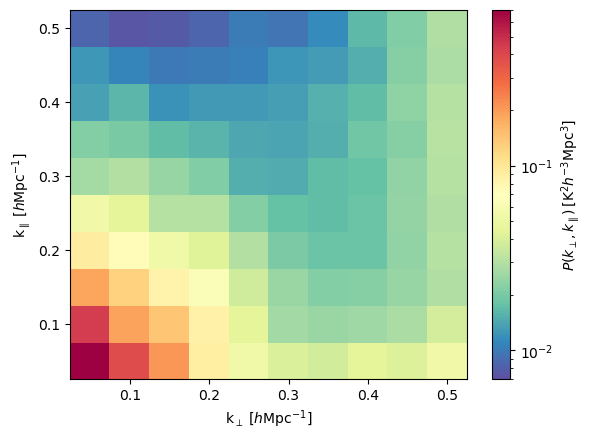

In [28]:
# Create a Cylindrically averaged PS and plot
ps_gen_sq = get_ps_gen_square(w_cube, fmin, primary_beam='ska_low', window_fct='hann', ft_method='nudft', rmean_freqs=False)
ps2d = set_kpar_max(ps_gen_sq.get_ps2d(w_cube))

plot_ps2d(
        ps2d.data, 
        kperp_bins, kpara_bins,
        cmap='Spectral_r', norm=colors.LogNorm(vmin=7e-3, vmax=7e-1), little_h=True,
        label=r'$P(k_\perp, k_\parallel)\, [\mathrm{K}^2 h^{-3} \mathrm{Mpc}^3]$'
)